<a href="https://colab.research.google.com/github/frsn49/Dados/blob/main/prv_1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Célula 1: Importações

In [1]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth, drive
from google.auth import default
import gspread
from gspread_dataframe import get_as_dataframe

# Configurações iniciais
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# Célula 2: Autenticação e montagem do Google Drive

In [2]:
auth.authenticate_user()
drive.mount('/content/drive')
creds, _ = default()
gc = gspread.authorize(creds)

Mounted at /content/drive


# Célula 3: Função para ler Google Sheets

In [3]:
def ler_gsheet(url):
    try:
        sheet = gc.open_by_url(url)
        worksheet = sheet.get_worksheet(0)
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        return df.dropna(how='all').dropna(axis=1, how='all')
    except Exception as e:
        print(f"Erro ao ler o arquivo: {str(e)}")
        return None

# Célula 4: Seleção e carregamento do dataset

In [5]:
print("Escolha o dataset:")
print("1 - Iris")
print("2 - Salmao")
print("3 - Wine Quality")
opcao = input("Digite a opção (1/2/3): ").strip()

try:
    if opcao == '1':
        # Tentativas para Iris
        try:
            df = pd.read_csv('/content/drive/MyDrive/IFCE/2025.1/INTELIGÊNCIA COMPUTACIONAL APLICADA/PROVA_1/iris.gsheet')
            print("Dataset Iris carregado localmente")
        except:
            try:
                df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                                header=None,
                                names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])
                print("Dataset Iris carregado do URL público")
            except Exception as e:
                print(f"Erro ao carregar Iris: {str(e)}")
                raise

    elif opcao == '2':
        # Tentativas para Salmão
        try:
            df = pd.read_csv('/content/drive/MyDrive/IFCE/2025.1/INTELIGÊNCIA COMPUTACIONAL APLICADA/PROVA_1/salmao.gsheet')
            print("Dataset Salmão carregado localmente")
        except:
            try:
                df = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/geyser.csv')
                print("Dataset Salmão carregado do URL público")
            except Exception as e:
                print(f"Erro ao carregar Salmão: {str(e)}")
                raise

    elif opcao == '3':
        # Tentativas para Wine Quality
        try:
            # Tentativa 1: Carregar localmente
            df = pd.read_csv('/content/drive/MyDrive/IFCE/2025.1/INTELIGÊNCIA COMPUTACIONAL APLICADA/PROVA_1/WineQT.gsheet', sep=';')
            print("Dataset Wine Quality carregado localmente")

            # Se tudo estiver em uma coluna (fallback)
            if df.shape[1] == 1:
                print("Aplicando correção para dados em formato incorreto...")
                df = df.iloc[:, 0].str.split(';', expand=True)
                # Nomear as colunas conforme o padrão Wine Quality
                df.columns = [
                    'fixed acidity', 'volatile acidity', 'citric acid',
                    'residual sugar', 'chlorides', 'free sulfur dioxide',
                    'total sulfur dioxide', 'density', 'pH', 'sulphates',
                    'alcohol', 'quality'
                ]

        except Exception as e:
            print(f"Erro ao carregar localmente: {str(e)}")
            try:
                # Tentativa 2: Carregar do URL padrão
                df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
                print("Dataset Wine Quality carregado do URL público")
            except Exception as e:
                print(f"Erro ao carregar Wine Quality: {str(e)}")
                raise

    else:
        raise ValueError("Opção inválida! Digite 1, 2 ou 3.")

    # Verificação pós-carregamento
    print("\nVerificação da estrutura do dataset:")
    print(f"Número de colunas: {df.shape[1]}")
    print(f"Nomes das colunas: {df.columns.tolist()}")
    print("\nPrimeiras linhas:")
    print(df.head())
    print("\nTipos de dados:")
    print(df.dtypes)

except Exception as e:
    print(f"\nErro ao carregar o dataset: {str(e)}")
    print("Verifique:")
    print("- O caminho/localização do arquivo")
    print("- Sua conexão com a internet")
    print("- O formato do arquivo")
    raise

Escolha o dataset:
1 - Iris
2 - Salmao
3 - Wine Quality
Digite a opção (1/2/3): 3
Erro ao carregar localmente: [Errno 95] Operation not supported: '/content/drive/MyDrive/IFCE/2025.1/INTELIGÊNCIA COMPUTACIONAL APLICADA/PROVA_1/WineQT.gsheet'
Dataset Wine Quality carregado do URL público

Verificação da estrutura do dataset:
Número de colunas: 12
Nomes das colunas: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Primeiras linhas:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70      

# Célula 5 : Pré-processamento dos dados

In [6]:
# Configuração automática e segura da coluna alvo
if opcao == '1':
    possible_targets = ['species', 'class', 'tipo', 'target', 'categoria']
    col_alvo = next((col for col in possible_targets if col in df.columns), None)
    if col_alvo is None:
        non_numeric_cols = df.select_dtypes(exclude=['number']).columns
        col_alvo = non_numeric_cols[-1] if len(non_numeric_cols) > 0 else df.columns[-1]

elif opcao == '2':
    col_alvo = df.columns[-1]  # Assume última coluna para Salmão/gêiser

elif opcao == '3':
    # Verificação robusta para Wine Quality
    if 'quality' in df.columns:
        col_alvo = 'quality'
    else:
        # Procura por colunas que podem ser a target
        possible_targets = ['quality', 'class', 'target', 'rating', 'score']
        col_alvo = next((col for col in possible_targets if col in df.columns), df.columns[-1])

print(f"\nColuna alvo identificada: '{col_alvo}'")
print(f"Tipo de dados: {df[col_alvo].dtype}")
print(f"Valores únicos: {df[col_alvo].unique()}")

# Pré-processamento robusto
try:
    # Identificação de colunas numéricas com verificação rigorosa
    numeric_cols = []
    for col in df.columns:
        if col != col_alvo:
            # Verifica se é numérico ou conversível
            if pd.api.types.is_numeric_dtype(df[col]):
                numeric_cols.append(col)
            else:
                try:
                    df[col] = pd.to_numeric(df[col], errors='raise')
                    numeric_cols.append(col)
                except:
                    print(f"Coluna '{col}' não pôde ser convertida para numérico")

    if not numeric_cols:
        # Última tentativa: pegar todas as colunas exceto a target
        numeric_cols = [col for col in df.columns if col != col_alvo]
        print(f"Usando todas as colunas disponíveis como features: {numeric_cols}")

    print(f"\nColunas de features selecionadas ({len(numeric_cols)}):")
    print(numeric_cols)

    # Verificação final
    if not numeric_cols:
        raise ValueError("Nenhuma coluna disponível para features!")

    # Pré-processamento
    X = df[numeric_cols].values
    X = StandardScaler().fit_transform(X)

    # Processamento da target
    y = df[col_alvo]
    if not pd.api.types.is_numeric_dtype(y):
        try:
            y = pd.to_numeric(y, errors='raise')
        except:
            y = LabelEncoder().fit_transform(y)
    y = y.astype(int)

    # Binarização para Wine Quality
    if len(np.unique(y)) > 2:
        if opcao == '3':
            median = np.median(y)
            y_bin = np.where(y >= median, 1, 0)
            print(f"\nBinarização: valores >= {median} → 1")
            print("Distribuição original:", dict(zip(*np.unique(y, return_counts=True))))
            print("Distribuição binária:", dict(zip(*np.unique(y_bin, return_counts=True))))
            y = y_bin
        else:
            minority_class = np.argmin(np.bincount(y))
            y = np.where(y == minority_class, 1, 0)

    print("\nDistribuição final das classes:")
    print(pd.Series(y).value_counts().to_string())

except Exception as e:
    print(f"\nErro no pré-processamento: {str(e)}")
    print("\nDebug info:")
    print("Colunas disponíveis:", df.columns.tolist())
    print("Tipos de dados:\n", df.dtypes)
    print("Primeiras linhas:\n", df.head())
    raise


Coluna alvo identificada: 'quality'
Tipo de dados: int64
Valores únicos: [5 6 7 4 8 3]

Colunas de features selecionadas (11):
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Binarização: valores >= 6.0 → 1
Distribuição original: {np.int64(3): np.int64(10), np.int64(4): np.int64(53), np.int64(5): np.int64(681), np.int64(6): np.int64(638), np.int64(7): np.int64(199), np.int64(8): np.int64(18)}
Distribuição binária: {np.int64(0): np.int64(744), np.int64(1): np.int64(855)}

Distribuição final das classes:
1    855
0    744


# Célula 6: Implementação do Perceptron

In [7]:
class Perceptron:
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter
        self.errors = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1] + 1)
        for _ in range(self.n_iter):
            error = 0
            for xi, target in zip(X, y):
                update = self.lr * (target - self.predict(xi))
                self.w[1:] += update * xi
                self.w[0] += update
                error += int(update != 0)
            self.errors.append(error)
        return self

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

    def net_input(self, X):
        return np.dot(X, self.w[1:]) + self.w[0]

    def plot_errors(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.errors) + 1), self.errors, marker='o')
        plt.xlabel('Épocas')
        plt.ylabel('Erros')
        plt.title('Curva de Aprendizado')
        plt.show()

# Célula 7: Funções de avaliação

In [8]:
def evaluate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    # Inicialização segura
    acc = prec = rec = f1 = 0.0

    # Verifica se a matriz de confusão tem o formato esperado
    if cm.shape == (2, 2):
        try:
            acc = (cm[1,1] + cm[0,0]) / cm.sum()
            prec = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
            rec = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
            f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        except:
            pass  # Mantém os valores padrão em caso de erro
    else:
        print("Aviso: Matriz de confusão com formato inesperado -", cm.shape)

    # Visualização
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Previsto 0', 'Previsto 1'],
                yticklabels=['Verdadeiro 0', 'Verdadeiro 1'])
    plt.title('Matriz de Confusão')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()

    print(classification_report(y_true, y_pred))
    return acc, prec, rec, f1

# Célula 8: Execução dos cenários


Método: ORIGINAL


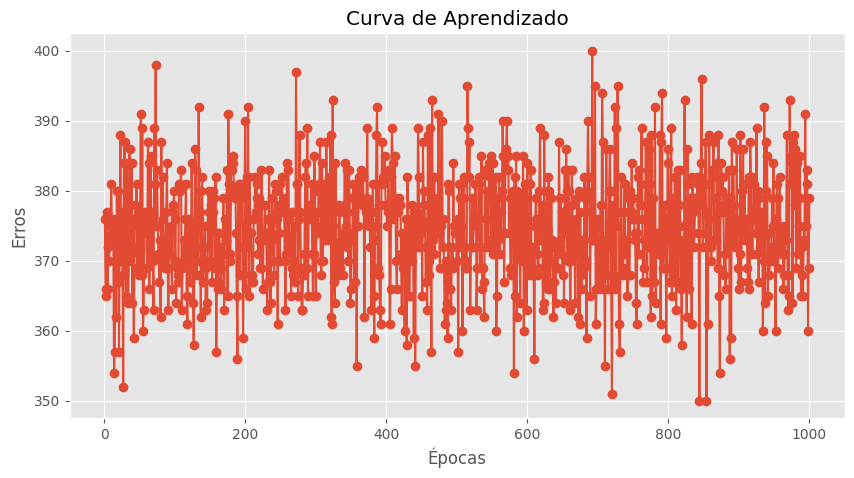

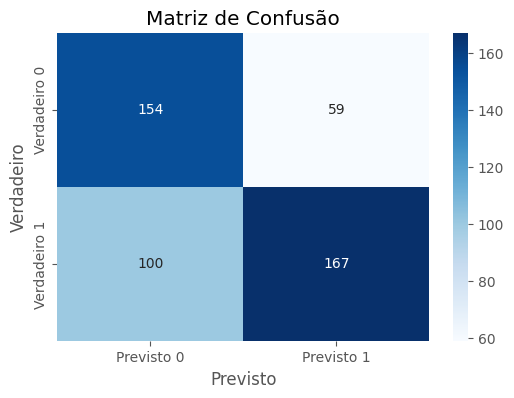

              precision    recall  f1-score   support

           0       0.61      0.72      0.66       213
           1       0.74      0.63      0.68       267

    accuracy                           0.67       480
   macro avg       0.67      0.67      0.67       480
weighted avg       0.68      0.67      0.67       480

Acurácia: 0.6687, Precisão: 0.7389, Recall: 0.6255, F1-Score: 0.6775

Método: SMOTE


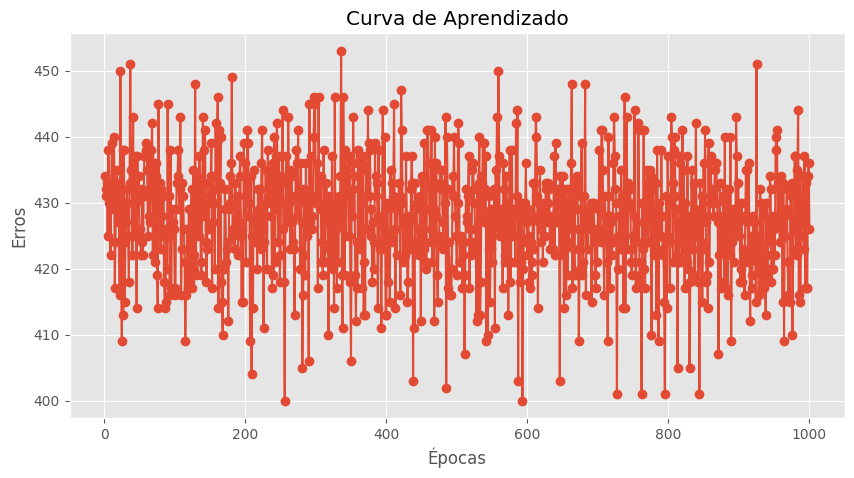

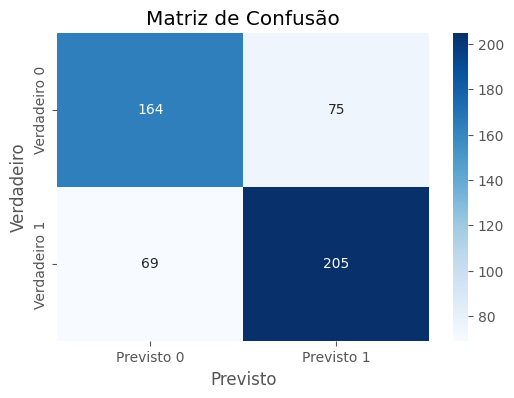

              precision    recall  f1-score   support

           0       0.70      0.69      0.69       239
           1       0.73      0.75      0.74       274

    accuracy                           0.72       513
   macro avg       0.72      0.72      0.72       513
weighted avg       0.72      0.72      0.72       513

Acurácia: 0.7193, Precisão: 0.7321, Recall: 0.7482, F1-Score: 0.7401

Método: UNDER


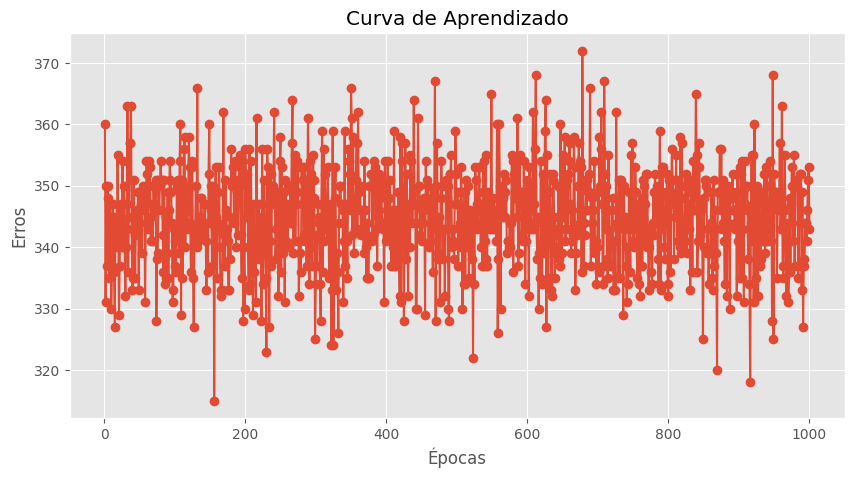

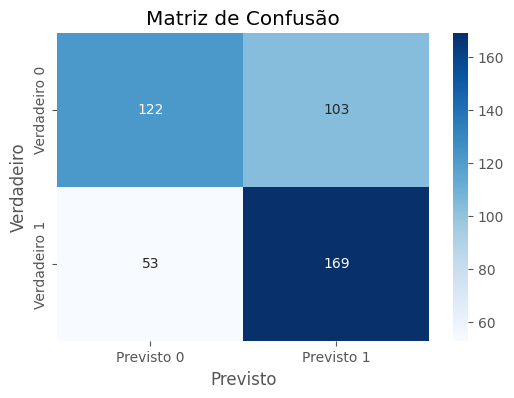

              precision    recall  f1-score   support

           0       0.70      0.54      0.61       225
           1       0.62      0.76      0.68       222

    accuracy                           0.65       447
   macro avg       0.66      0.65      0.65       447
weighted avg       0.66      0.65      0.65       447

Acurácia: 0.6510, Precisão: 0.6213, Recall: 0.7613, F1-Score: 0.6842

Análise concluída!


In [9]:
for metodo in ['original', 'smote', 'under']:
    print(f"\n{'='*50}\nMétodo: {metodo.upper()}\n{'='*50}")

    if metodo == 'smote':
        X_res, y_res = SMOTE(random_state=42).fit_resample(X, y) if len(np.unique(y)) > 1 and min(np.bincount(y)) > 1 else (X, y)
    elif metodo == 'under':
        X_res, y_res = RandomUnderSampler(random_state=42).fit_resample(X, y)
    else:
        X_res, y_res = X, y

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

    model = Perceptron(lr=0.01, n_iter=1000).fit(X_train, y_train)
    model.plot_errors()

    acc, prec, rec, f1 = evaluate(y_test, model.predict(X_test))
    print(f"Acurácia: {acc:.4f}, Precisão: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")

print("\nAnálise concluída!")